#### ✅ **제목 전처리 외 처리 과정**

**[CONTENTS & VOD]**

1. disp_rtm_min(object -> 초단위로 변경)
2. 모든 컬럼이 동일한 행 제거
3. cont_log_dt 에서 날짜 ('cont_log_date’), 시간대 ('cont_log_hour’), 요일(’strt_dat_of_week’) 추출해서 추가
4. (VOD) subsr,'vod_strip', strt_date 별로 use_tms 합 컬럼 추가
5. (VOD) sebsr 별 상세보기 클릭 횟수(CONT) 를 ‘cont_count’ 컬럼 추가

**[이상치 제거]**

1. 모든 컬럼이 동일한 행 제거
2. 일별 총 시청시간 합 (use_tms)이 5분 이하인 경우는 이상치로 간주하고 삭제
3. content에는 존재하지만 vod에는 존재하지 않는 행 *→ 일단 보류*

**[평가기준]**
- 클릭율? use_tms? 할것인지 확인 필요
- 우선은 total_user_tms로 진행함
- 상세보기(cont)은 개수 변수로 추가함


**[FM 모델]**
- Mean Squared Error: 19.9856
- 우선은 total_use_tms 예측하는 것으로 구현함
- total_use_tms 에 따라 10월 시청 여부로 바꾸는 것도 고려중


[+추가 고려사항]
- 평가기준 설정
- disp_rtm : 1분이나 2분은 광고나 예고편으로 간주 -> 제거하는게 좋을지


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
from itertools import chain
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# 데이터 읽기
vod_aug = pd.read_csv('/content/drive/MyDrive/dxdata/데이터스쿨_3차_VOD_2308.csv', sep="\t", encoding= 'cp949')
vod_sep = pd.read_csv('/content/drive/MyDrive/dxdata/데이터스쿨_3차_VOD_2309.csv', sep="\t", encoding= 'cp949')
cont_aug = pd.read_csv('/content/drive/MyDrive/dxdata/데이터스쿨_3차_콘텐츠_2308.csv', sep="\t", encoding= 'cp949')
cont_sep = pd.read_csv('/content/drive/MyDrive/dxdata/데이터스쿨_3차_콘텐츠_2309.csv', sep="\t", encoding= 'cp949')

columns = ['subsr', 'chnl_nm', 'in_dt', 'use_tms', 'pgm_nm',  'summary',   'cast',   'program_duration_minutes']
channel_aug = pd.read_csv('/content/drive/MyDrive/dxdata/데이터스쿨3차_채널PGM_2308월.csv', encoding = 'CP949', usecols= columns)
channel_sep = pd.read_csv('/content/drive/MyDrive/dxdata/데이터스쿨3차_채널PGM_2309월.csv', encoding='cp949', usecols= columns)

<ipython-input-4-b4a1e256b96a>:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  channel_aug = pd.read_csv('/content/drive/MyDrive/dxdata/데이터스쿨3차_채널PGM_2308월.csv', encoding = 'CP949', usecols= columns)
<ipython-input-4-b4a1e256b96a>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  channel_sep = pd.read_csv('/content/drive/MyDrive/dxdata/데이터스쿨3차_채널PGM_2309월.csv', encoding='cp949', usecols= columns)


In [ ]:
vod_aug

In [ ]:
channel_aug

In [ ]:
vod_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5615 entries, 0 to 5614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subsr           5615 non-null   int64 
 1   asset_nm        5615 non-null   object
 2   ct_cl           5615 non-null   object
 3   genre_of_ct_cl  5615 non-null   object
 4   use_tms         5615 non-null   int64 
 5   SMRY            5612 non-null   object
 6   ACTR_DISP       5612 non-null   object
 7   disp_rtm        5615 non-null   object
 8   strt_dt         5615 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 394.9+ KB


In [ ]:
cont_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15677 entries, 0 to 15676
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   subsr           15677 non-null  int64 
 1   series_nm       7516 non-null   object
 2   super_asset_nm  15677 non-null  object
 3   ct_cl           15677 non-null  object
 4   genre_of_ct_cl  15677 non-null  object
 5   SMRY            15677 non-null  object
 6   ACTR_DISP       15677 non-null  object
 7   disp_rtm        14512 non-null  object
 8   log_dt          15677 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 1.1+ MB


#### ✅ [제목 전처리]
=> 새로운 데이터 맞춰서 추후 반영 예정

In [ ]:
#전처리 함수

#pinfo(괄호 데이터) 추출
def get_pinfo(li):
    pattern = re.compile('\(([^)]+)')
    return [pattern.findall(str(i)) for i in li]

#pinfo(괄호 데이터) 제거
def remove_pinfo(li):
    pattern = r'\([^)]*\)'
    temp = []
    for i in li:
        tmp = re.sub(pattern, repl = '', string = str(i))
        temp = np.append(temp, tmp)
    return temp

#괄호 안의 업로드 날짜 추출
def get_upload_date(li):
    pattern = re.compile('\d+/\d+/\d+')
    return [pattern.findall(str(i)) for i in li]

#괄호 안의 업로드 날짜 제거
def remove_upload_date(li):
    pattern = r'\d+/\d+/\d+'
    temp = []
    for i in li:
        tmp = re.sub(pattern, repl = '', string = str(i))
        temp.append(tmp)
    return temp

#회차 정보 제거
def remove_series(li):
    pattern = r'\s{0,1}\d{1,7}[회,화]\s{0,1}'
    temp = []
    for i in li:
        tmp = re.sub(pattern, repl = '', string = str(i))
        temp = np.append(temp, tmp)
    return temp

#공백 제거
def remove_space(li):
    temp = []
    for i in li:
        tmp = str(i).replace(" ", "")
        temp = np.append(temp, tmp)
    return temp

#맨 뒤에 . 붙어있는거 제거
def remove_punkt(li):
    temp = []
    for i in li:
        if i[-1] == '.':
            temp.append(i[:-1])
        else:
            temp.append(i)
    return temp

In [ ]:
upload_date = get_upload_date(vod_aug.asset_nm.values)
upload_date = [date for sub_date in upload_date for date in (sub_date or [np.nan])]
vod_aug['upload_date'] = upload_date
vod_aug['upload_date'] = pd.to_datetime(vod_aug.upload_date, format = '%y/%m/%d')

In [ ]:
#vod df에 추가할 vod 이름만 추출
vod_name = remove_upload_date(vod_aug.asset_nm.values)

vod_pinfo = get_pinfo(vod_name)
vod_aug['pinfo'] = vod_pinfo

# vod08['pinfo'] = vod08['pinfo'].str.get()
vod_aug['pinfo'] =  vod_aug['pinfo'].apply(lambda x: str(x).replace('[','').replace(']',''))

vod_pinfo = list(chain(*vod_pinfo))
vod_pinfo = pd.Series(vod_pinfo).unique()

vod_name = remove_pinfo(vod_name)
vod_name = remove_series(vod_name)


In [ ]:
cont_name = cont_aug.super_asset_nm.fillna('X').values
cont_pinfo = get_pinfo(cont_name)

series_name = cont_aug.series_nm.fillna('X').values
series_pinfo = get_pinfo(series_name)

cont_pinfo_all = [list(set(sum([p1,p2], []))) for p1, p2 in zip(cont_pinfo, series_pinfo)]
cont_aug['pinfo'] = cont_pinfo_all
cont_aug['pinfo'] = cont_aug['pinfo'].apply(lambda x: str(x).replace('[', '').replace(']', ''))

cont_pinfo = list(chain(*cont_pinfo_all))
cont_pinfo = pd.Series(cont_pinfo).unique()

cont_name = remove_pinfo(cont_aug.super_asset_nm.values)
cont_name = remove_series(cont_name)

In [ ]:
vod_name = remove_punkt(vod_name)
cont_name = remove_punkt(cont_name)

In [ ]:
vod_aug['vod_name'] = vod_name
cont_aug['cont_name'] = cont_name

In [ ]:
## 9월
upload_date = get_upload_date(vod_sep.asset_nm.values)
upload_date = [date for sub_date in upload_date for date in (sub_date or [np.nan])]
vod_sep['upload_date'] = upload_date
vod_sep['upload_date'] = pd.to_datetime(vod_sep.upload_date, format = '%y/%m/%d')

In [ ]:
#vod df에 추가할 content 이름만 추출
vod_name2 = remove_upload_date(vod_sep.asset_nm.values)

vod_pinfo2 = get_pinfo(vod_name2)
vod_sep['pinfo'] = vod_pinfo2

# vod08['pinfo'] = vod08['pinfo'].str.get()
vod_sep['pinfo'] =  vod_sep['pinfo'].apply(lambda x: str(x).replace('[','').replace(']',''))

vod_pinfo2 = list(chain(*vod_pinfo2))
vod_pinfo2 = pd.Series(vod_pinfo2).unique()

vod_name2 = remove_pinfo(vod_name2)
vod_name2 = remove_series(vod_name2)
cont_name2 = cont_sep.super_asset_nm.fillna('X').values
cont_pinfo2 = get_pinfo(cont_name2)

series_name2 = cont_sep.series_nm.fillna('X').values
series_pinfo2 = get_pinfo(series_name2)

cont_pinfo_all2 = [list(set(sum([p1,p2], []))) for p1, p2 in zip(cont_pinfo2, series_pinfo2)]
cont_sep['pinfo'] = cont_pinfo_all2
cont_sep['pinfo'] = cont_sep['pinfo'].apply(lambda x: str(x).replace('[', '').replace(']', ''))

cont_pinfo2 = list(chain(*cont_pinfo_all2))
cont_pinfo2 = pd.Series(cont_pinfo2).unique()
cont_name2 = remove_pinfo(cont_sep.super_asset_nm.values)
cont_name2 = remove_series(cont_name2)
vod_name2 = remove_punkt(vod_name2)
cont_name2 = remove_punkt(cont_name2)

vod_sep['vod_name'] = vod_name2
cont_sep['cont_name'] = cont_name2

In [ ]:
## 추가전처리
#8월 데이터

#백설 공주
#vod -> 백설 공주 / cont -> 백설공주 (55,56)

#내생애가장아름다운일주일
#vod -> 내 생애 가장 아름다운 일주일 / cont -> 내생애가장아름다운일주일 (9160 ~ 9165)

#vod쪽으로 통합 (space 있는 버전 )

cont_aug.loc[56, 'cont_name']= '백설 공주'
cont_aug.loc[8047, 'cont_name'] = '내 생애 가장 아름다운 일주일'
#9월 데이터

#링
# vod -> 링(space) / cont -> 링
#vod를 링으로 변경 (68)

#장화신은 고양이
#vod -> 장화 신은 고양이 / cont -> 장화신은 고양이
#vod를 장화신은 고양이로 변경 (google 검색 기준) (2830)

#vod -> 장화신은고양이 / cont -> 장화신은 고양이
#vod 변경 (google 기준) (3500, 3501)


#내 생애 가장 아름다운 일주일
#vod -> 내 생애 가장 아름다운 일주일 / cont -> 내생애가장아름다운일주일
#cont 변경 -> space 추가 (8044 - 8047)

vod_sep.loc[3501, 'vod_name']= '장화신은 고양이'

In [ ]:
vod_strip = remove_space(vod_aug.vod_name.values)
cont_strip = remove_space(cont_aug.cont_name.values)

vod_strip2 = remove_space(vod_sep.vod_name.values)
cont_strip2 = remove_space(cont_sep.cont_name.values)
vod_aug['vod_strip'] = vod_strip
cont_aug['cont_strip'] = cont_strip

vod_sep['vod_strip'] = vod_strip2
cont_sep['cont_strip'] = cont_strip2

# 빈칸 제거
set1 = set(vod_aug.vod_strip.unique()).difference(set(cont_aug.cont_strip.unique())) # 183
li1 = list(set1)

set11 = set(vod_sep.vod_strip.unique()).difference(set(cont_sep.cont_strip.unique())) # 183
li11 = list(set11)
st1 = []
for i in li1:
    st1.append(vod_aug[vod_aug.vod_strip == i].index.tolist()[0])

st11 = []
for i in li11:
    st11.append(vod_sep[vod_sep.vod_strip == i].index.tolist()[0])
set2 = set(vod_aug.vod_name.unique()).difference(set(cont_aug.cont_name.unique())) # 185
li2 = list(set2)

set22 = set(vod_sep.vod_name.unique()).difference(set(cont_sep.cont_name.unique())) # 185
li22 = list(set22)
st2 = []
for i in li2:
    st2.append(vod_aug[vod_aug.vod_name == i].index.tolist()[0])

st22 = []
for i in li22:
    st22.append(vod_sep[vod_sep.vod_name == i].index.tolist()[0])
cont_sep[(cont_sep.super_asset_nm.notnull()) & (cont_sep.super_asset_nm.str.contains('내생애가장'))]
vod_sep[vod_sep.vod_name == '장화신은 고양이']
cont_sep[cont_sep.cont_name == '장화신은 고양이']

,subsr,series_nm,super_asset_nm,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,pinfo,cont_name,cont_strip
11084,66056000,NaN,장화신은 고양이,영화,애니메이션,본 콘텐츠는 평생소장 콘텐츠로 서비스 해지 시까지 시청이 가능합니다. 한때는 알아주...,"안토니오 반데라스,셀마 헤이엑,자흐 칼리피아나키스",NaN,20230918050931,,장화신은 고양이,장화신은고양이
11085,63086000,NaN,장화신은 고양이,영화,애니메이션,본 콘텐츠는 평생소장 콘텐츠로 서비스 해지 시까지 시청이 가능합니다. 한때는 알아주...,"안토니오 반데라스,셀마 헤이엑,자흐 칼리피아나키스",NaN,20230924160207,,장화신은 고양이,장화신은고양이
11086,63086000,NaN,장화신은 고양이,영화,애니메이션,본 콘텐츠는 평생소장 콘텐츠로 서비스 해지 시까지 시청이 가능합니다. 한때는 알아주...,"안토니오 반데라스,셀마 헤이엑,자흐 칼리피아나키스",NaN,20230924160126,,장화신은 고양이,장화신은고양이
11087,63086000,NaN,장화신은 고양이,영화,애니메이션,본 콘텐츠는 평생소장 콘텐츠로 서비스 해지 시까지 시청이 가능합니다. 한때는 알아주...,"안토니오 반데라스,셀마 헤이엑,자흐 칼리피아나키스",NaN,20230924160152,,장화신은 고양이,장화신은고양이
11088,63086000,NaN,장화신은 고양이,영화,애니메이션,본 콘텐츠는 평생소장 콘텐츠로 서비스 해지 시까지 시청이 가능합니다. 한때는 알아주...,"안토니오 반데라스,셀마 헤이엑,자흐 칼리피아나키스",NaN,20230924160201,,장화신은 고양이,장화신은고양이


In [ ]:
li = cont_sep[(cont_sep.super_asset_nm.notnull()) & (cont_sep.super_asset_nm.str.contains('짱구는 못말려: 동물소환 닌자'))].index.tolist()
cont_sep[(cont_sep.super_asset_nm.notnull()) & (cont_sep.super_asset_nm.str.contains('짱구는 못말려: 동물소환 닌자'))]
li = vod_aug[(vod_aug.asset_nm.notnull()) & (vod_aug.asset_nm.str.contains('짱구는 못말려: 수수께끼! 꽃피는'))].index.tolist()
vod_aug[(vod_aug.asset_nm.notnull()) & (vod_aug.asset_nm.str.contains('펜트하우스2히든룸'))]
for i in li:
    cont_sep.loc[i, 'cont_name'] = '짱구는 못말려: 동물소환 닌자 배꼽수비대'
cont_sep.loc[39, 'cont_name'] = '해리포터와마법사의돌:매지컬무비모드'

#### [이외 전처리]
1. disp_rtm_min(object -> 초단위로 변경)
2. 모든 컬럼이 동일한 행 제거
3. 컬럼 추가

In [ ]:
cont08 = cont_aug.copy()
cont09 = cont_sep.copy()
vod08 = vod_aug.copy()
vod09 = vod_sep.copy()
channel08 = channel_aug.copy()
channel09 = channel_sep.copy()

disp_rtm_min (초단위로 변경)

In [ ]:
# disp_rtm_min(object -> 초단위로 변경)
from datetime import datetime

cont08['disp_rtm'] = pd.to_datetime(cont08['disp_rtm'], format='%H:%M').dt.time # datetime 형식으로 변환
cont08['disp_rtm_sec']= cont08['disp_rtm'].apply(lambda x: x.hour * 3600 + x.minute*60)
cont09['disp_rtm'] = pd.to_datetime(cont09['disp_rtm'], format='%H:%M').dt.time # datetime 형식으로 변환
cont09['disp_rtm_sec']= cont09['disp_rtm'].apply(lambda x: x.hour * 3600 + x.minute*60)

In [ ]:
from datetime import datetime

vod08['disp_rtm'] = pd.to_datetime(vod08['disp_rtm'], format='%H:%M').dt.time # datetime 형식으로 변환
vod08['disp_rtm_sec']= vod08['disp_rtm'].apply(lambda x: x.hour * 3600 + x.minute*60)
vod09['disp_rtm'] = pd.to_datetime(vod09['disp_rtm'], format='%H:%M').dt.time # datetime 형식으로 변환
vod09['disp_rtm_sec']= vod09['disp_rtm'].apply(lambda x: x.hour * 3600 + x.minute*60)

In [ ]:
vod09.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5042 entries, 0 to 5041
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subsr           5042 non-null   int64         
 1   asset_nm        5042 non-null   object        
 2   ct_cl           5042 non-null   object        
 3   genre_of_ct_cl  5042 non-null   object        
 4   use_tms         5042 non-null   int64         
 5   SMRY            5041 non-null   object        
 6   ACTR_DISP       5041 non-null   object        
 7   disp_rtm        5042 non-null   object        
 8   strt_dt         5042 non-null   int64         
 9   upload_date     2039 non-null   datetime64[ns]
 10  pinfo           5042 non-null   object        
 11  vod_name        5042 non-null   object        
 12  vod_strip       5042 non-null   object        
 13  disp_rtm_sec    5042 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(9)
memory usage: 

In [ ]:
cont08['log_dt'] = cont08['log_dt'].astype(str)
cont09['log_dt'] = cont09['log_dt'].astype(str)

# 날짜 부분 추출 및 datetime 형식으로 변환
cont08['cont_log_date'] = pd.to_datetime(cont08['log_dt'].str[:8], format='%Y%m%d', errors='coerce')
cont09['cont_log_date'] = pd.to_datetime(cont09['log_dt'].str[:8], format='%Y%m%d', errors='coerce')

# Hour
cont08['cont_log_hour'] = cont08['log_dt'].str[8:10].astype(int)
cont09['cont_log_hour'] = cont09['log_dt'].str[8:10].astype(int)

In [ ]:
vod08['strt_dt'] = vod08['strt_dt'].astype(str)
vod09['strt_dt'] = vod09['strt_dt'].astype(str)

# 날짜 부분 추출 및 datetime 형식으로 변환
vod08['strt_date'] = pd.to_datetime(vod08['strt_dt'].str[:8], format='%Y%m%d', errors='coerce')
vod09['strt_date'] = pd.to_datetime(vod09['strt_dt'].str[:8], format='%Y%m%d', errors='coerce')

# Hour
vod08['strt_hour'] = vod08['strt_dt'].str[8:10].astype(int)
vod09['strt_hour'] = vod09['strt_dt'].str[8:10].astype(int)

In [ ]:
import pandas as pd

def extract_datetime_info(df, date_column_name):
#     df[date_column_name] = df[date_column_name].astype(str)

#     df['year'] = df[date_column_name].str[:4]
#     df['minute'] = df[date_column_name].str[10:12]
#     df['sec'] = df[date_column_name].str[12:14]
#     df['month'] = df[date_column_name].str[4:6]
#     df['date'] = df[date_column_name].str[6:8]
#     df['hour'] = df[date_column_name].str[8:10]


#     df[date_column_name] = df[date_column_name].str[:8]
#     df[date_column_name] = pd.to_datetime(df[date_column_name], format='%Y%m%d')
    df['strt_day_of_week'] = df[date_column_name].dt.strftime('%A')
    return df

cont08 = extract_datetime_info(cont08, 'cont_log_date')
cont09 = extract_datetime_info(cont09, 'cont_log_date')

vod08 = extract_datetime_info(vod08, 'strt_date')
vod09 = extract_datetime_info(vod09, 'strt_date')

모든 컬럼이 동일한 행 제거

In [ ]:
def remove_duplicate(df):
    df = df.drop_duplicates(keep='first')
    print("남아있는 중복행 :", df[df.duplicated(keep=False)])

In [ ]:
remove_duplicate(cont08)
remove_duplicate(cont09)

남아있는 중복행 : Empty DataFrame
Columns: [subsr, series_nm, super_asset_nm, ct_cl, genre_of_ct_cl, SMRY, ACTR_DISP, disp_rtm, log_dt, pinfo, cont_name, cont_strip, disp_rtm_sec, cont_log_date, cont_log_hour, strt_day_of_week]
Index: []
남아있는 중복행 : Empty DataFrame
Columns: [subsr, series_nm, super_asset_nm, ct_cl, genre_of_ct_cl, SMRY, ACTR_DISP, disp_rtm, log_dt, pinfo, cont_name, cont_strip, disp_rtm_sec, cont_log_date, cont_log_hour, strt_day_of_week]
Index: []


In [ ]:
remove_duplicate(vod08)
remove_duplicate(vod09)

남아있는 중복행 : Empty DataFrame
Columns: [subsr, asset_nm, ct_cl, genre_of_ct_cl, use_tms, SMRY, ACTR_DISP, disp_rtm, strt_dt, upload_date, pinfo, vod_name, vod_strip, disp_rtm_sec, strt_date, strt_hour, strt_day_of_week]
Index: []
남아있는 중복행 : Empty DataFrame
Columns: [subsr, asset_nm, ct_cl, genre_of_ct_cl, use_tms, SMRY, ACTR_DISP, disp_rtm, strt_dt, upload_date, pinfo, vod_name, vod_strip, disp_rtm_sec, strt_date, strt_hour, strt_day_of_week]
Index: []


[CONTENT] disp_rtm_min 누락된 행 확인

In [ ]:
print(cont08[cont08['disp_rtm_sec'].isnull()]['cont_strip'].nunique())
print(cont08[cont08['disp_rtm_sec']==0]['cont_strip'].nunique())

412
52


In [ ]:
print(cont09[cont09['disp_rtm_sec'].isnull()]['cont_strip'].nunique())
print(cont09[cont09['disp_rtm_sec']==0]['cont_strip'].nunique())

386
48


In [ ]:
# # CONT (disp_rtm 값이 NAN + 0)
# cont08 = cont08.fillna({'disp_rtm_min': 0})
# cont09 = cont09.fillna({'disp_rtm_min': 0})

# # li1 = cont08[cont08['disp_rtm_min'].isnull()]['cont_strip'].unique()
# li2 = cont08[cont08['disp_rtm_min']==0]['cont_strip'].unique()

# # li3 = cont09[cont09['disp_rtm_min'].isnull()]['cont_strip'].unique()
# li4 = cont09[cont09['disp_rtm_min']==0]['cont_strip'].unique()

# Nan_disp_rtm = list(set(np.append(li2, li4)))

# file_name = './cont_disp_rtm_NAN.txt'

# with open(file_name, 'w+') as file:
#     file.write('\n'.join(Nan_disp_rtm))

In [ ]:
# len(Nan_disp_rtm) # 총 936개

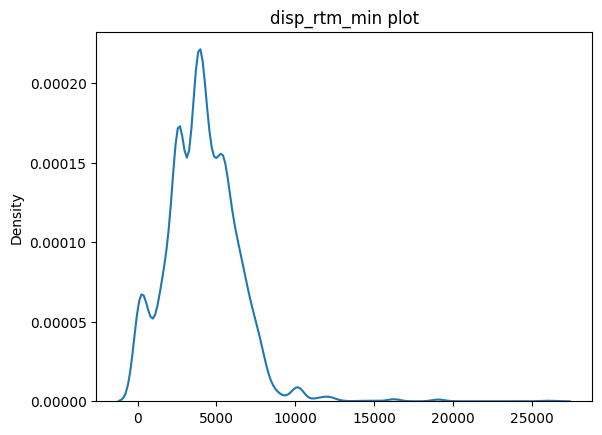

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

x = vod08.disp_rtm_sec.values

sns.kdeplot(x)
plt.title("disp_rtm_min plot")
plt.show()

In [ ]:
# ns.boxplot(x="day", y="total_bill", data=tips)
# plt.title("요일 별 전체 팁의 Box Plot")
# plt.show()

In [ ]:
# # 모든 컬럼이 동일한 행 찾기
# duplicates = cont08[cont08.duplicated(keep=False)]

# # 모든 컬럼이 동일한 행 제거
# cont08_1 = cont08[cont08.duplicated(keep='first')]

# # 결과 출력
# print("동일한 행:")
# duplicates

In [ ]:
# print(cont08[cont08.duplicated(keep=False)])

#### *장르 기반으로 군집화했을 때 기타가 너무 많음

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 장르를 one-hot 인코딩으로 변환
genre_dummies = pd.get_dummies(vod08['genre_of_ct_cl'])

# 사용자별로 장르 정보를 합치기
user_genre_data = pd.concat([vod08['subsr'], genre_dummies], axis=1).groupby('subsr').sum()

# 군집화를 위한 표준화
scaler = StandardScaler()
user_genre_data_scaled = scaler.fit_transform(user_genre_data)

# KMeans 알고리즘을 사용하여 군집화
num_clusters = 5  # 군집의 개수를 설정
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
user_clusters = kmeans.fit_predict(user_genre_data_scaled)

# 군집 결과를 데이터프레임에 추가
user_genre_data['cluster'] = user_clusters

# 각 군집에 대한 개인화된 알고리즘을 적용하고 추천 생성
for cluster_num in range(num_clusters):
    cluster_data = user_genre_data[user_genre_data['cluster'] == cluster_num]

    # 여기에 해당 군집에 속한 사용자에게 개인화된 추천을 생성하는 로직을 추가하세요.
    # cluster_data를 사용하여 해당 군집에 속한 사용자의 시청 이력을 분석하고 추천을 생성합니다.

    # 해당 군집에 속한 사용자의 시청 이력 출력
    print(f"Cluster {cluster_num} 사용자의 시청 이력:")
    print(cluster_data.drop(columns='cluster'))

    # 여기에 해당 군집에 속한 사용자에게 개인화된 추천을 생성하는 로직 추가
    # 예시로, 각 장르별 시청 횟수를 계산하여 가장 많이 시청한 장르를 기반으로 추천
    genre_counts = cluster_data.iloc[:, :-1].sum(axis=0)
    most_watched_genre = genre_counts.idxmax()

    # 해당 군집의 사용자들에게 추천할 콘텐츠 선택
    recommendations = vod08[vod08['genre_of_ct_cl'] == most_watched_genre]['vod_name'].unique()

    print(f"Cluster {cluster_num} 추천 콘텐츠: {recommendations}")
    print("="*50)

Cluster 0 사용자의 시청 이력:
          SF/환타지  공포/스릴러  기타  다큐멘터리  단편  드라마  로맨틱코미디  멜로  명랑/코믹  무협  ...  역사  \
subsr                                                                ...       
59879000       0       0  14      0   0    0       0   0      0   0  ...   0   
59900000       0       0   2      0   0    3       0   2      0   0  ...   0   
59921000       0       0   0      0   0    3       0   1      0   0  ...   0   
59930000       0       0  20      0   0    0       0   1      0   0  ...   0   
59933000       0       0  12      0   0    0       0   0      0   0  ...   0   
...          ...     ...  ..    ...  ..  ...     ...  ..    ...  ..  ...  ..   
67096000       0       0   0      0   0    0       0   0      0   0  ...   0   
67107000       0       0   0      0   0    0       0   0      0   0  ...   0   
67117000       0       0   3      0   0    0       0   0      0   0  ...   0   
67122000       0       0   0      0   0    0       0   0      0   0  ...   0   
67126000       0  

In [ ]:
user_genre_data[user_genre_data['cluster']==0]

,SF/환타지,공포/스릴러,기타,다큐멘터리,단편,드라마,로맨틱코미디,멜로,명랑/코믹,무협,...,연예/오락,오락,외화 시리즈,인물,인물/다큐,추리/미스터리,코미디,학습,학원/순정/연애,cluster
subsr,,,,,,,,,,,,,,,,,,,,,
59879000,0,0,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59900000,0,0,2,0,0,3,0,2,0,0,...,0,0,0,0,0,0,1,0,0,0
59921000,0,0,0,0,0,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
59930000,0,0,20,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
59933000,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67096000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67107000,0,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,0,0,0,0
67117000,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 모델 적용을 위한 처리 과정

In [ ]:
cont08_1 = cont08[['subsr', 'cont_strip', 'ct_cl', 'genre_of_ct_cl',
        'disp_rtm_sec', 'cont_log_date', 'cont_log_hour','strt_day_of_week']]
cont09_1 = cont09[['subsr', 'cont_strip', 'ct_cl', 'genre_of_ct_cl',
        'disp_rtm_sec', 'cont_log_date', 'cont_log_hour','strt_day_of_week']]

In [ ]:
vod08_1 = vod08[['subsr', 'vod_strip', 'ct_cl', 'genre_of_ct_cl', 'use_tms',
        'disp_rtm_sec', 'strt_date', 'strt_hour','strt_day_of_week']]
vod09_1 = vod09[['subsr', 'vod_strip', 'ct_cl', 'genre_of_ct_cl', 'use_tms',
        'disp_rtm_sec', 'strt_date', 'strt_hour','strt_day_of_week']]

In [ ]:
# VOD 일별 합
# subsr,'vod_strip', strt_date 별로 use_tms 합 컬럼 추가

vod08_1['total_use_tms'] = vod08_1.groupby(['subsr', 'vod_strip', 'strt_date'])['use_tms'].transform('sum')
vod08_1 = vod08_1.drop_duplicates(subset=['subsr', 'vod_strip', 'strt_date'])

vod09_1['total_use_tms'] = vod09_1.groupby(['subsr', 'vod_strip', 'strt_date'])['use_tms'].transform('sum')
vod09_1 = vod09_1.drop_duplicates(subset=['subsr', 'vod_strip', 'strt_date'])

vod09_1

<ipython-input-45-e395de464ead>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vod08_1['total_use_tms'] = vod08_1.groupby(['subsr', 'vod_strip', 'strt_date'])['use_tms'].transform('sum')
<ipython-input-45-e395de464ead>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vod09_1['total_use_tms'] = vod09_1.groupby(['subsr', 'vod_strip', 'strt_date'])['use_tms'].transform('sum')


,subsr,vod_strip,ct_cl,genre_of_ct_cl,use_tms,disp_rtm_sec,strt_date,strt_hour,strt_day_of_week,total_use_tms
0,64385000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,7,4260,2023-09-20,15,Wednesday,4327
1,65819000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,4260,4260,2023-09-17,4,Sunday,17460
2,66744000,인간극장,TV 시사/교양,기타,1920,1920,2023-09-29,14,Friday,2674
3,66885000,인간극장,TV 시사/교양,기타,1980,1980,2023-09-13,10,Wednesday,5820
4,62421000,과학수사대스모킹건,TV 시사/교양,기타,0,3660,2023-09-01,23,Friday,902
...,...,...,...,...,...,...,...,...,...,...
5036,66900000,핑크퐁자동차동화,키즈,학습,11,240,2023-09-04,12,Monday,11
5037,60169000,간질간질,키즈,학습,360,360,2023-09-14,21,Thursday,360
5038,66317000,알사탕,키즈,학습,480,480,2023-09-03,22,Sunday,680
5040,66900000,월간아기상어,키즈,학습,46,60,2023-09-04,12,Monday,46


In [ ]:
# cont08_1.groupby(['subsr','cont_log_date','cont_strip']).count()
# cont09_1.groupby(['subsr','cont_log_date','cont_strip']).count()
# vod08_1.groupby(['subsr','strt_date','vod_strip']).count()

In [ ]:
# 8월 데이터
# cont08_1을 groupby하여 count 계산
cont_count = cont08_1.groupby(['subsr', 'cont_log_date', 'cont_strip']).size().reset_index(name='cont_count')

# vod08_1과 cont_count을 병합하여 cont_count 열 추가
vod08_1 = pd.merge(vod08_1, cont_count, how='left', left_on=['subsr', 'strt_date', 'vod_strip'],
                   right_on=['subsr', 'cont_log_date', 'cont_strip'])

# NaN 값을 0으로 채우기 (count가 없는 경우)
vod08_1['cont_count'] = vod08_1['cont_count'].fillna(0).astype(int)

# 불필요한 컬럼 제거
vod08_1 = vod08_1.drop(['cont_log_date', 'cont_strip'], axis=1)

In [ ]:
# 9월 데이터 반영
cont_count = cont09_1.groupby(['subsr', 'cont_log_date', 'cont_strip']).size().reset_index(name='cont_count')

vod09_1 = pd.merge(vod09_1, cont_count, how='left', left_on=['subsr', 'strt_date', 'vod_strip'],
                   right_on=['subsr', 'cont_log_date', 'cont_strip'])

# NaN 값을 0으로 채우기 (count가 없는 경우)
vod09_1['cont_count'] = vod09_1['cont_count'].fillna(0).astype(int)

# 불필요한 컬럼 제거
vod09_1 = vod09_1.drop(['cont_log_date', 'cont_strip'], axis=1)

In [ ]:
# 5분 이하로 본 것은 이상치로 간주하고 삭제

vod08_1 = vod08_1[vod08_1['total_use_tms']>300]
vod09_1 = vod09_1[vod09_1['total_use_tms']>300]

In [ ]:
vod09_1

,subsr,vod_strip,ct_cl,genre_of_ct_cl,use_tms,disp_rtm_sec,strt_date,strt_hour,strt_day_of_week,total_use_tms,cont_count
0,64385000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,7,4260,2023-09-20,15,Wednesday,4327,3
1,65819000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,4260,4260,2023-09-17,4,Sunday,17460,1
2,66744000,인간극장,TV 시사/교양,기타,1920,1920,2023-09-29,14,Friday,2674,2
3,66885000,인간극장,TV 시사/교양,기타,1980,1980,2023-09-13,10,Wednesday,5820,6
4,62421000,과학수사대스모킹건,TV 시사/교양,기타,0,3660,2023-09-01,23,Friday,902,1
...,...,...,...,...,...,...,...,...,...,...,...
1647,66317000,이파라파냐무냐무,키즈,학습,720,720,2023-09-05,19,Tuesday,720,0
1648,62844000,엄마가화났다,키즈,학습,480,480,2023-09-22,8,Friday,480,0
1649,60169000,간질간질,키즈,학습,360,360,2023-09-14,21,Thursday,360,0
1650,66317000,알사탕,키즈,학습,480,480,2023-09-03,22,Sunday,680,0


#### 모델 재시도 (=> Mean Squared Error: 19.9856)

In [ ]:
vod_combined = pd.concat([vod08_1, vod09_1], axis=0, ignore_index=True)
vod_combined

,subsr,vod_strip,ct_cl,genre_of_ct_cl,disp_rtm_sec,strt_hour,strt_day_of_week,cont_count,total_use_tms
0,65941000,그것이알고싶다,TV 시사/교양,기타,4800,16,Saturday,2,8820
1,66873000,그것이알고싶다,TV 시사/교양,기타,4800,20,Wednesday,2,6245
2,66873000,그것이알고싶다,TV 시사/교양,기타,4800,19,Tuesday,3,12064
3,61689000,그것이알고싶다,TV 시사/교양,기타,4800,13,Sunday,2,4800
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,4380,9,Friday,2,4183
...,...,...,...,...,...,...,...,...,...
3494,66317000,이파라파냐무냐무,키즈,학습,720,19,Tuesday,0,720
3495,62844000,엄마가화났다,키즈,학습,480,8,Friday,0,480
3496,60169000,간질간질,키즈,학습,360,21,Thursday,0,360
3497,66317000,알사탕,키즈,학습,480,22,Sunday,0,680


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, recall_score, f1_score

# 데이터 로드
# vod_df = vod08_1.copy()
vod_df = vod_combined.copy()

# subsr를 범주형으로 변경
vod_df['subsr'] = vod_df['subsr'].astype(object)

# Object 컬럼에 대해 One-hot Encoding
categorical_columns = ['subsr', 'vod_strip', 'ct_cl', 'genre_of_ct_cl', 'strt_day_of_week']
encoders = []
encoded_features = []

for col in categorical_columns:
    one_hot_encoder = OneHotEncoder(sparse=False)
    encoded_column = one_hot_encoder.fit_transform(vod_df[col].values.reshape(-1, 1))
    encoded_features.append(encoded_column)

# 정규화가 필요한 열들
columns_to_normalize = ['disp_rtm_sec', 'strt_hour', 'cont_count', 'total_use_tms']
minmax_scaler = MinMaxScaler()
vod_df[columns_to_normalize] = minmax_scaler.fit_transform(vod_df[columns_to_normalize])

# encoding 및 정규화된 특성 결합
X = np.hstack(encoded_features + [vod_df[columns_to_normalize]])

# target 설정
y = vod_df['total_use_tms'].astype(float)

# 데이터를 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# FM 모델 정의
class FM(tf.keras.Model):
    def __init__(self):
        super(FM, self).__init__()

        # 모델의 파라미터 정의
        self.w_0 = tf.Variable([0.0])
        self.w = tf.Variable(tf.zeros(X.shape[1]))
        self.V = tf.Variable(tf.random.normal(shape=(X.shape[1], 10)))

    def call(self, inputs):
        linear_terms = tf.reduce_sum(tf.math.multiply(self.w, inputs), axis=1)

        interactions = 0.5 * tf.reduce_sum(
            tf.math.pow(tf.matmul(inputs, self.V), 2)
            - tf.matmul(tf.math.pow(inputs, 2), tf.math.pow(self.V, 2)),
            1,
            keepdims=False
        )

        y_hat = self.w_0 + linear_terms + interactions

        return y_hat

# 모델 초기화
model = FM()

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))

# 모델 예측
y_pred = model.predict(X_test)

# 평균 제곱 오차(Mean Squared Error) 계산
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Epoch 1/10
350/350 [==============================] - 4s 6ms/step - loss: 93.0345 - val_loss: 80.9290
Epoch 2/10
350/350 [==============================] - 1s 4ms/step - loss: 64.1083 - val_loss: 61.7867
Epoch 3/10
350/350 [==============================] - 1s 4ms/step - loss: 47.7573 - val_loss: 50.1051
Epoch 4/10
350/350 [==============================] - 1s 3ms/step - loss: 37.1005 - val_loss: 41.9080
Epoch 5/10
350/350 [==============================] - 1s 4ms/step - loss: 29.5637 - val_loss: 35.8591
Epoch 6/10
350/350 [==============================] - 1s 4ms/step - loss: 23.9600 - val_loss: 31.1479
Epoch 7/10
350/350 [==============================] - 1s 4ms/step - loss: 19.6766 - val_loss: 27.4309
Epoch 8/10
350/350 [==============================] - 3s 8ms/step - loss: 16.3132 - val_loss: 24.4730
Epoch 9/10
350/350 [==============================] - 1s 4ms/step - loss: 13.6433 - val_loss: 22.0151
Epoch 10/10
22/22 [==============================] - 0s 6ms/step
Mean Squared Erro

In [ ]:
sample_index = 1
sample_prediction = y_pred[sample_index]
actual_value = y_test.iloc[sample_index]

print(f"Predicted Value: {sample_prediction:.4f}")
print(f"Actual Value: {actual_value:.4f}")
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"평균 제곱 오차: {mse:.4f}")

Predicted Value: -3.8872
Actual Value: 0.9501
평균 제곱 오차: 19.9856


#### FM 모델 (오류존재)

In [ ]:
from IPython.core.display import display, HTML
display(HTML(""))

In [ ]:
# ! pip install deepctr-torch

In [ ]:
import torch
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *

In [ ]:
vod08_1

,subsr,vod_strip,ct_cl,genre_of_ct_cl,use_tms,disp_rtm_sec,strt_date,strt_hour,strt_day_of_week,total_use_tms,cont_count
0,65941000,그것이알고싶다,TV 시사/교양,기타,4800,4800,2023-08-12,16,Saturday,8820,2
1,66873000,그것이알고싶다,TV 시사/교양,기타,4800,4800,2023-08-16,20,Wednesday,6245,2
2,66873000,그것이알고싶다,TV 시사/교양,기타,718,4800,2023-08-29,19,Tuesday,12064,3
3,61689000,그것이알고싶다,TV 시사/교양,기타,4800,4800,2023-08-13,13,Sunday,4800,2
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,4183,4380,2023-08-04,9,Friday,4183,2
...,...,...,...,...,...,...,...,...,...,...,...
2433,67106000,라바시즌1,키즈,오락,780,780,2023-08-25,15,Friday,790,0
2434,66317000,알사탕,키즈,학습,480,480,2023-08-10,22,Thursday,480,0
2436,66317000,꽃에서나온코끼리,키즈,학습,420,420,2023-08-19,14,Saturday,420,0
2437,66317000,수박수영장,키즈,학습,480,480,2023-08-10,23,Thursday,480,0


In [ ]:
def feature_selection(data):
    print("\n\n2. feature selection ")

    sparse_features = data.columns.tolist()
    sparse_features.remove('use_tms')
    sparse_features.remove('hour')
    dense_features = ['hour']

    print("sparse feature :", sparse_features)
    print("dense feature :", dense_features)
    print("target :", 'total_use_tms')

    return data, sparse_features, dense_features


In [ ]:
vod08_1 = vod08_1.drop('use_tms', axis=1)
vod09_1 = vod09_1.drop('use_tms', axis=1)

In [ ]:
vod08_1 = vod08_1.drop('strt_date', axis=1)
vod09_1 = vod09_1.drop('strt_date', axis=1)

In [ ]:
vod08_1 = vod08_1[['subsr', 'vod_strip', 'ct_cl', 'genre_of_ct_cl', 'disp_rtm_sec',
        'strt_hour', 'strt_day_of_week', 'cont_count','total_use_tms']]
vod09_1 = vod09_1[['subsr', 'vod_strip', 'ct_cl', 'genre_of_ct_cl', 'disp_rtm_sec',
        'strt_hour', 'strt_day_of_week', 'cont_count','total_use_tms']]

In [ ]:
vod08_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1847 entries, 0 to 2443
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subsr             1847 non-null   int64 
 1   vod_strip         1847 non-null   object
 2   ct_cl             1847 non-null   object
 3   genre_of_ct_cl    1847 non-null   object
 4   disp_rtm_sec      1847 non-null   int64 
 5   strt_hour         1847 non-null   int64 
 6   strt_day_of_week  1847 non-null   object
 7   cont_count        1847 non-null   int64 
 8   total_use_tms     1847 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 144.3+ KB


In [ ]:
#원핫인코딩
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.metrics import BinaryAccuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

vod_data = np.array(vod08_1)
X = vod_data[:, :-1]
y = vod_data[:, -1].astype(float)

# subsr 는 범주형으로 변경해주기
X[:, 0] = X[:, 0].astype(object)

# Object 컬럼에 대해 One-hot Encoding
categorical_columns = [0,1,2,3,6] #subsr, vod_strip, ct_cl, genre_of_ct_cl, strt_day_of_week
encoders = []
encoded_features = []

for col in categorical_columns:
    one_hot_encoder = OneHotEncoder(sparse=False)
    encoded_column = one_hot_encoder.fit_transform(X[:, col].reshape(-1, 1))
    encoded_features.append(encoded_column)

# 'disp_rtm_sec','strt_hour', 'strt_day_of_week', 'cont_count','total_use_tms'
# 컬럼에 대한 정규화필요

# 정규화가 필요한 열들
columns_to_normalize = [4, 5, 7]
scaler = StandardScaler()
X[:, columns_to_normalize] = scaler.fit_transform(X[:, columns_to_normalize])
print(X[:, columns_to_normalize])

# 범주형 + 정규화 열들 결합
X = np.hstack(encoded_features + [X[:, columns_to_normalize]])
print("\nX : \n", X)

# 데이터를 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nX_train :\n", X_train)

[[0.07704486553648059 0.28416793896947934 -0.2413859763397464]
 [0.07704486553648059 0.9220994895943695 -0.2413859763397464]
 [0.07704486553648059 0.762616601938147 0.0415073601447153]
 ...
 [-1.8385067230951286 -0.03479783634296571 -0.8071726493086698]
 [-1.8122662903741478 1.400548152563037 -0.8071726493086698]
 [-1.7073045594902239 1.2410652649068146 -0.8071726493086698]]

X : 
 [[0.0 0.0 0.0 ... 0.07704486553648059 0.28416793896947934
  -0.2413859763397464]
 [0.0 0.0 0.0 ... 0.07704486553648059 0.9220994895943695
  -0.2413859763397464]
 [0.0 0.0 0.0 ... 0.07704486553648059 0.762616601938147
  0.0415073601447153]
 ...
 [0.0 0.0 0.0 ... -1.8385067230951286 -0.03479783634296571
  -0.8071726493086698]
 [0.0 0.0 0.0 ... -1.8122662903741478 1.400548152563037
  -0.8071726493086698]
 [0.0 0.0 0.0 ... -1.7073045594902239 1.2410652649068146
  -0.8071726493086698]]

X_train :
 [[0.0 0.0 0.0 ... 2.412443377703785 0.4436508266257019 1.7388673790514857]
 [0.0 0.0 0.0 ... 0.33944919274629004 -0.0

In [ ]:
y_train

array([9779., 4306., 1761., ..., 3581., 5696., 1380.])

#### TensorFlow를 사용하여 FM 모델을 정의하고, SGD(Stochastic Gradient Descent)를 통해 모델을 학습하고 테스트
- 코드상 에러로 결과값이 제대로 적용이 되지 않음!

In [ ]:
# GPU 확인
tf.config.list_physical_devices('GPU')

# 자료형 선언
tf.keras.backend.set_floatx('float32')

In [ ]:
# 데이터 로드
# scaler = MinMaxScaler()
# # file = load_breast_cancer()
# # X, Y = file['data'], file['target']
# # X = scaler.fit_transform(X)

# n = X.shape[0]
# p = X.shape[1]
k = 10
# batch_size = 8
# epochs = 10

class FM(tf.keras.Model):
    def __init__(self):
        super(FM, self).__init__()

        # 모델의 파라미터 정의
        self.w_0 = tf.Variable([0.0]) #편향
        self.w = tf.Variable(tf.zeros(X.shape[1])) #선형 가중치
        self.V = tf.Variable(tf.random.normal(shape=(X.shape[1], k))) #상호작용 가중

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.w_0 = self.add_weight(shape=(1,), initializer='zeros', trainable=True, name='w_0')
        self.w = self.add_weight(shape=(input_dim,), initializer='zeros', trainable=True, name='w')
        self.V = self.add_weight(shape=(input_dim, 10), initializer='random_normal', trainable=True, name='V')
        super(FM, self).build(input_shape)

    def call(self, inputs):
        linear_terms = tf.reduce_sum(tf.math.multiply(self.w, inputs), axis=1)

        interactions = 0.5 * tf.reduce_sum(
            tf.math.pow(tf.matmul(inputs, self.V), 2)
            - tf.matmul(tf.math.pow(inputs, 2), tf.math.pow(self.V, 2)),
            1,
            keepdims=False
        )


        y_hat = tf.math.sigmoid(self.w_0 + linear_terms + interactions)

        return y_hat

# Forward
def train_on_batch(model, optimizer, loss_fn, inputs, targets):
    with tf.GradientTape() as tape:
        y_pred = model(inputs)
        loss = loss_fn(y_true=targets, y_pred=y_pred)
        # accuracy: update할 때마다 정확도는 누적되어 계산된다.
        accuracy = BinaryAccuracy(threshold=0.5
                                  )
    # loss를 모델의 파라미터로 편미분하여 gradients를 구한다.
    grads = tape.gradient(target=loss, sources=model.trainable_variables)
    for grad, var in zip(grads, model.trainable_variables):
      print(f'변수: {var.name}, 형태: {var.shape}, 그래디언트: {grad}')

    if any(grad is not None for grad in grads):
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # apply_gradients()를 통해 processed gradients를 적용한다.
    # optimizer.apply_gradients(zip(grads, model.trainable_variables))

    accuracy.update_state(targets, y_pred)
    return loss


# 반복 학습 함수
def train(epochs):
    for i in range(epochs):

        train_ds = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), y_train.astype(np.float32))).shuffle(500).batch(8)
        test_ds = tf.data.Dataset.from_tensor_slices((X_test.astype(np.float32), y_test.astype(np.float32))).shuffle(200).batch(8)

        model = FM()
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        accuracy = BinaryAccuracy(threshold=0.5)  # 각 epoch마다 초기화
        loss_history = []

        for x, y_batch in train_ds:
            loss = train_on_batch(model, optimizer, accuracy, x, y_batch)
            loss_history.append(loss)

        if i % 10 == 0:
            print("step {:03d} : 누적 평균 손실 = {:.4f}".format(i, np.mean(loss_history)))
            print("step {:03d} : 누적 정확도    = {:.4f}".format(i, accuracy.result().numpy()))

        test_accuracy = BinaryAccuracy(threshold=0.5)
        for x, y_batch in test_ds:
            y_pred = model(x)
            test_accuracy.update_state(y_batch, y_pred)

        print("테스트 정확도: {:.4f}".format(test_accuracy.result().numpy()))

In [ ]:
# Train the modified FM model on VOD data
# epochs값을 적절하게 설정하여 함수 호출
train(5)

In [ ]:
X_train

array([[0.0, 0.0, 0.0, ..., 2.412443377703785, 0.4436508266257019,
        1.7388673790514857],
       [0.0, 0.0, 0.0, ..., 0.33944919274629004, -0.03479783634296571,
        -0.2413859763397464],
       [0.0, 0.0, 0.0, ..., 1.389066501585528, -0.03479783634296571,
        -0.8071726493086698],
       ...,
       [0.0, 0.0, 0.0, ..., -0.3165616252782336, -0.6727293869678559,
        0.0415073601447153],
       [0.0, 0.0, 0.0, ..., 3.3046180902171374, 1.2410652649068146,
        -0.8071726493086698],
       [0.0, 0.0, 0.0, ..., -1.4186597995594334, 0.9220994895943695,
        -0.8071726493086698]], dtype=object)

In [ ]:
y_train

array([9779., 4306., 1761., ..., 3581., 5696., 1380.])

In [ ]:
import re

# Assuming vod_data[:, -1] is the column you want to check
non_numeric_indices = [i for i, value in enumerate(vod_data[:, -1]) if not re.match(r'^-?\d+\.?\d*$', str(value))]
non_numeric_values = vod_data[non_numeric_indices, -1]

print(non_numeric_values)

[]


In [ ]:
# 데이터 전처리
vod_data = np.array(vod08_1)
X = vod_data[:, :-1]
y = vod_data[:, -1].astype(float)

# print(X)
# print(y)

# subsr는 범주형으로 변경
X[:, 0] = X[:, 0].astype(object)

# Object 컬럼에 대해 One-hot Encoding
categorical_columns = [0, 1, 2, 3, 6]  # subsr, vod_strip, ct_cl, genre_of_ct_cl, strt_day_of_week
encoders = []
encoded_features = []

for col in categorical_columns:
    one_hot_encoder = OneHotEncoder(sparse=False)
    encoded_column = one_hot_encoder.fit_transform(X[:, col].reshape(-1, 1))
    encoded_features.append(encoded_column)
# print(encoded_features)

# 정규화가 필요한 열들
columns_to_normalize = [4, 5, 7]
scaler = StandardScaler()
X[:, columns_to_normalize] = scaler.fit_transform(X[:, columns_to_normalize])
# print(X[:, columns_to_normalize])
# 원핫 인코딩된 특성과 정규화된 특성 결합
X = np.hstack(encoded_features + [X[:, columns_to_normalize]])
# print(X)

# 데이터를 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train)

[[0.0 0.0 0.0 ... 2.412443377703785 0.4436508266257019 1.7388673790514857]
 [0.0 0.0 0.0 ... 0.33944919274629004 -0.03479783634296571
  -0.2413859763397464]
 [0.0 0.0 0.0 ... 1.389066501585528 -0.03479783634296571
  -0.8071726493086698]
 ...
 [0.0 0.0 0.0 ... -0.3165616252782336 -0.6727293869678559
  0.0415073601447153]
 [0.0 0.0 0.0 ... 3.3046180902171374 1.2410652649068146
  -0.8071726493086698]
 [0.0 0.0 0.0 ... -1.4186597995594334 0.9220994895943695
  -0.8071726493086698]]


In [ ]:
vod08_1.head(3)

,subsr,vod_strip,ct_cl,genre_of_ct_cl,disp_rtm_sec,strt_hour,strt_day_of_week,cont_count,total_use_tms
0,65941000,그것이알고싶다,TV 시사/교양,기타,4800,16,Saturday,2,8820
1,66873000,그것이알고싶다,TV 시사/교양,기타,4800,20,Wednesday,2,6245
2,66873000,그것이알고싶다,TV 시사/교양,기타,4800,19,Tuesday,3,12064


In [ ]:

# FM 모델 정의
class FM(tf.keras.Model):
    def __init__(self):
        super(FM, self).__init__()

        # 모델의 파라미터 정의
        self.w_0 = tf.Variable([0.0])  # 편향
        self.w = tf.Variable(tf.zeros(X.shape[1]))  # 선형 가중치
        self.V = tf.Variable(tf.random.normal(shape=(X.shape[1], k)))  # 상호작용 가중

    def call(self, inputs):
        linear_terms = tf.reduce_sum(tf.math.multiply(self.w, inputs), axis=1)

        interactions = 0.5 * tf.reduce_sum(
            tf.math.pow(tf.matmul(inputs, self.V), 2)
            - tf.matmul(tf.math.pow(inputs, 2), tf.math.pow(self.V, 2)),
            1,
            keepdims=False
        )

        y_hat = tf.math.sigmoid(self.w_0 + linear_terms + interactions)

        return y_hat

# Forward
def train_on_batch(model, optimizer, accuracy, inputs, targets):
    with tf.GradientTape() as tape:
        y_pred = model(inputs)
        loss = tf.keras.losses.binary_crossentropy(from_logits=False,
                                                   y_true=targets,
                                                   y_pred=y_pred)

    # loss를 모델의 파라미터로 편미분하여 gradients를 구한다.
    grads = tape.gradient(target=loss, sources=model.trainable_variables)

    # apply_gradients()를 통해 processed gradients를 적용한다.
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # accuracy: update할 때마다 정확도는 누적되어 계산된다.
    accuracy.update_state(targets, y_pred)

    return loss

# 반복 학습 함수
def train(epochs):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), y_train.astype(np.float32))).shuffle(500).batch(8)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test.astype(np.float32), y_test.astype(np.float32))).shuffle(200).batch(8)

    model = FM()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    accuracy = BinaryAccuracy()  # 각 epoch마다 초기화
    loss_history = []

    for x, y_batch in train_ds:  # 수정된 부분: y_batch로 변수명 변경
      loss = train_on_batch(model, optimizer, accuracy, x, y_batch)
      loss_history.append(loss)

    if i % 10 == 0:
      print("step {:03d} : 누적 평균 손실 = {:.4f}".format(i, np.mean(loss_history)))
      print("step {:03d} : 누적 정확도    = {:.4f}".format(i, accuracy.result().numpy()))

    test_accuracy = BinaryAccuracy(threshold=0.5)
    for x, y_batch in test_ds:  # 수정된 부분: y_batch로 변수명 변경
        y_pred = model(x)
        test_accuracy.update_state(y_batch, y_pred)  # 수정된 부분: y_batch로 변수명 변경

    print("테스트 정확도: {:.4f}".format(test_accuracy.result().numpy()))

train(10)

테스트 정확도: 0.0000


In [ ]:
vod_data = np.array(vod08_1)
vod_data

array([[65941000, '그것이알고싶다', 'TV 시사/교양', ..., 'Saturday', 2, 8820],
       [66873000, '그것이알고싶다', 'TV 시사/교양', ..., 'Wednesday', 2, 6245],
       [66873000, '그것이알고싶다', 'TV 시사/교양', ..., 'Tuesday', 3, 12064],
       ...,
       [66317000, '꽃에서나온코끼리', '키즈', ..., 'Saturday', 0, 420],
       [66317000, '수박수영장', '키즈', ..., 'Thursday', 0, 480],
       [66317000, '이파라파냐무냐무', '키즈', ..., 'Thursday', 0, 880]],
      dtype=object)

In [ ]:
X = vod_data[:, :-1]
y = vod_data[:, -1].astype(float)

In [ ]:
X

array([[65941000, '그것이알고싶다', 'TV 시사/교양', ..., 16, 'Saturday', 2],
       [66873000, '그것이알고싶다', 'TV 시사/교양', ..., 20, 'Wednesday', 2],
       [66873000, '그것이알고싶다', 'TV 시사/교양', ..., 19, 'Tuesday', 3],
       ...,
       [66317000, '꽃에서나온코끼리', '키즈', ..., 14, 'Saturday', 0],
       [66317000, '수박수영장', '키즈', ..., 23, 'Thursday', 0],
       [66317000, '이파라파냐무냐무', '키즈', ..., 22, 'Thursday', 0]], dtype=object)

In [ ]:
y

array([ 8820.,  6245., 12064., ...,   420.,   480.,   880.])

#### 예제 코드 뜯어보기

In [ ]:
# FM
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# GPU 확인
tf.config.list_physical_devices('GPU')

# 자료형 선언
tf.keras.backend.set_floatx('float32')

# 데이터 로드
scaler = MinMaxScaler()
file = load_breast_cancer()
X, Y = file['data'], file['target']
# print(X)
print(Y)
X = scaler.fit_transform(X)
print(X)

n = X.shape[0]
p = X.shape[1]
k = 10
batch_size = 8
epochs = 10

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 

In [ ]:
file

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [ ]:
class FM(tf.keras.Model):
    def __init__(self):
        super(FM, self).__init__()

        # 모델의 파라미터 정의
        self.w_0 = tf.Variable([0.0])
        self.w = tf.Variable(tf.zeros([p]))
        self.V = tf.Variable(tf.random.normal(shape=(p, k)))

    def call(self, inputs):
        linear_terms = tf.reduce_sum(tf.math.multiply(self.w, inputs), axis=1)

        interactions = 0.5 * tf.reduce_sum(
            tf.math.pow(tf.matmul(inputs, self.V), 2)
            - tf.matmul(tf.math.pow(inputs, 2), tf.math.pow(self.V, 2)),
            1,
            keepdims=False
        )

        y_hat = tf.math.sigmoid(self.w_0 + linear_terms + interactions)

        return y_hat

In [ ]:
# Forward
def train_on_batch(model, optimizer, accuracy, inputs, targets):
    with tf.GradientTape() as tape:
        y_pred = model(inputs)
        loss = tf.keras.losses.binary_crossentropy(from_logits=False,
                                                   y_true=targets,
                                                   y_pred=y_pred)

    # loss를 모델의 파라미터로 편미분하여 gradients를 구한다.
    grads = tape.gradient(target=loss, sources=model.trainable_variables)

    # apply_gradients()를 통해 processed gradients를 적용한다.
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # accuracy: update할 때마다 정확도는 누적되어 계산된다.
    accuracy.update_state(targets, y_pred)

    return loss


# 반복 학습 함수
def train(epochs):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

    train_ds = tf.data.Dataset.from_tensor_slices(
        (tf.cast(X_train, tf.float32), tf.cast(Y_train, tf.float32))).shuffle(500).batch(8)

    test_ds = tf.data.Dataset.from_tensor_slices(
        (tf.cast(X_test, tf.float32), tf.cast(Y_test, tf.float32))).shuffle(200).batch(8)

    model = FM()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    accuracy = BinaryAccuracy(threshold=0.5)
    loss_history = []

    for i in range(epochs):
      for x, y in train_ds:
          loss = train_on_batch(model, optimizer, accuracy, x, y)
          loss_history.append(loss)

      if i % 2== 0:
          print("스텝 {:03d}에서 누적 평균 손실: {:.4f}".format(i, np.mean(loss_history)))
          print("스텝 {:03d}에서 누적 정확도: {:.4f}".format(i, accuracy.result().numpy()))


    test_accuracy = BinaryAccuracy(threshold=0.5)
    for x, y in test_ds:
        y_pred = model(x)
        test_accuracy.update_state(y, y_pred)

    print("테스트 정확도: {:.4f}".format(test_accuracy.result().numpy()))

In [ ]:
train(50)

스텝 000에서 누적 평균 손실: 2.1599
스텝 000에서 누적 정확도: 0.3692
스텝 002에서 누적 평균 손실: 1.4327
스텝 002에서 누적 정확도: 0.4440
스텝 004에서 누적 평균 손실: 1.0671
스텝 004에서 누적 정확도: 0.5692
스텝 006에서 누적 평균 손실: 0.8645
스텝 006에서 누적 정확도: 0.6581
스텝 008에서 누적 평균 손실: 0.7373
스텝 008에서 누적 정확도: 0.7143
스텝 010에서 누적 평균 손실: 0.6501
스텝 010에서 누적 정확도: 0.7526
스텝 012에서 누적 평균 손실: 0.5864
스텝 012에서 누적 정확도: 0.7802
스텝 014에서 누적 평균 손실: 0.5377
스텝 014에서 누적 정확도: 0.8010
스텝 016에서 누적 평균 손실: 0.4993
스텝 016에서 누적 정확도: 0.8181
스텝 018에서 누적 평균 손실: 0.4682
스텝 018에서 누적 정확도: 0.8315
스텝 020에서 누적 평균 손실: 0.4423
스텝 020에서 누적 정확도: 0.8425
스텝 022에서 누적 평균 손실: 0.4205
스텝 022에서 누적 정확도: 0.8523
스텝 024에서 누적 평균 손실: 0.4018
스텝 024에서 누적 정확도: 0.8606
스텝 026에서 누적 평균 손실: 0.3856
스텝 026에서 누적 정확도: 0.8679
스텝 028에서 누적 평균 손실: 0.3714
스텝 028에서 누적 정확도: 0.8742
스텝 030에서 누적 평균 손실: 0.3588
스텝 030에서 누적 정확도: 0.8798
스텝 032에서 누적 평균 손실: 0.3475
스텝 032에서 누적 정확도: 0.8846
스텝 034에서 누적 평균 손실: 0.3374
스텝 034에서 누적 정확도: 0.8889
스텝 036에서 누적 평균 손실: 0.3282
스텝 036에서 누적 정확도: 0.8929
스텝 038에서 누적 평균 손실: 0.3198
스텝 038에서 누적 정확도: 0.8964
